In [2]:
%load_ext autoreload
%autoreload 2

from krxns.config import filepaths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact


In [3]:
# Set this
n_chunks = 1
split_idx = 1
experiment = "test"
condition = "test_cond"
log_dir = filepaths["spl_cv"] / experiment / condition / f"split_{split_idx}"

<Axes: xlabel='epoch'>

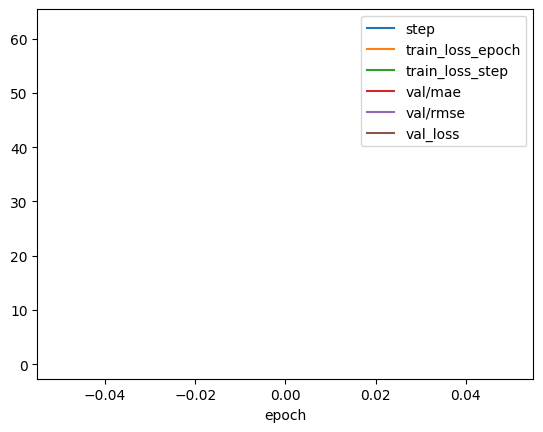

In [4]:
# Loss curves
lc = pd.read_csv(log_dir / "metrics.csv", sep=',')
ep_ave_lc = lc.groupby('epoch').agg('mean').reset_index() # Average over epochs
ep_ave_lc.head()
ep_ave_lc.plot(x="epoch")

In [5]:
lc.head()

,epoch,step,train_loss_epoch,train_loss_step,val/mae,val/rmse,val_loss
0,0,49,NaN,0.445803,NaN,NaN,NaN
1,0,69,NaN,NaN,0.693376,0.875441,0.766397
2,0,69,0.78866,NaN,NaN,NaN,NaN
